# [Sartorius - Cell Instance Segmentation](https://www.kaggle.com/c/petfinder-pawpularity-score)
> Detect single neuronal cells in microscopy images

![](https://storage.googleapis.com/kaggle-competitions/kaggle/30201/logos/header.png?t=2021-09-03-15-27-46)

# Notebooks:
* Train: [Sartorius: MMDetection [Train]](https://www.kaggle.com/awsaf49/sartorius-mmdetection-train)
* Infer: [Sartorius: MMDetection [Infer]](https://www.kaggle.com/awsaf49/sartorius-mmdetection-infer)

# Please Upvote If you find this notebook Useful :)

# Install Libraries

In [1]:
!rsync -a ../input/mmdetection-v280/mmdetection ../
!pip install ../input/mmdetection-v280/src/mmdet-2.8.0/mmdet-2.8.0/
!pip install ../input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3/
!pip install ../input/mmdetection-v280/src/addict-2.4.0-py3-none-any.whl
!pip install ../input/mmdetection-v280/src/yapf-0.30.0-py2.py3-none-any.whl
!pip install ../input/mmdetection-v280/src/mmcv_full-1.2.6-cp37-cp37m-manylinux1_x86_64.whl

Processing /kaggle/input/mmdetection-v280/src/mmdet-2.8.0/mmdet-2.8.0
  Created wheel for mmdet: filename=mmdet-2.8.0-py3-none-any.whl size=502141 sha256=41dd40f7d6f4d60f29478f6dd64ef54c028d6f67d573edaf504db93341c420df
  Stored in directory: /root/.cache/pip/wheels/ae/ca/90/3616110259678ffe2ef41fd1470981d081a340886954465c71
Successfully built mmdet
Processing /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3
  Created wheel for mmpycocotools: filename=mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl size=272908 sha256=3ed71de0b30c9ddd839e7fd856c73aa28c8c2ace80c01f3371dbc2ac370d8e6d
  Stored in directory: /root/.cache/pip/wheels/80/e0/da/3288fdf3965b5c9090f368462db9d28be2c82013f51821090a
Successfully built mmpycocotools
Processing /kaggle/input/mmdetection-v280/src/addict-2.4.0-py3-none-any.whl
Processing /kaggle/input/mmdetection-v280/src/yapf-0.30.0-py2.py3-none-any.whl
Processing /kaggle/input/mmdetection-v280/src/mmcv_full-1.2.6-cp37-cp37m-manylinux1_x86_6

In [2]:
import pandas as pd
import numpy as np
import cupy as cp
from glob import glob
import os
import cv2
from tqdm.notebook import tqdm
import pickle
from itertools import groupby
from pycocotools import mask as mutils
from pycocotools import _mask as coco_mask
import matplotlib.pyplot as plt
import os
import base64
import typing as t
import zlib
import random
random.seed(0)


# Meta Data

In [3]:
conf_name = "mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco"
model_name = 'epoch_8'
ROOT = '../input/sartorius-cell-instance-segmentation'
train_or_test = 'test'

# Test Data
df  = pd.DataFrame(glob(ROOT+f'/{train_or_test}/*'), columns=['image_path'])
df['id'] = df.image_path.map(lambda x: x.split('/')[-1].split('.')[0])
# df= df.sample(frac=20, replace=True)
display(df.head())

,image_path,id
0,../input/sartorius-cell-instance-segmentation/...,7ae19de7bc2a
1,../input/sartorius-cell-instance-segmentation/...,d8bfd1dafdc4
2,../input/sartorius-cell-instance-segmentation/...,d48ec7815252


# Helper Function

In [4]:
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""
    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode()

def mask2rle(msk):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    msk    = cp.array(msk)
    pixels = msk.flatten()
    pad    = cp.array([0])
    pixels = cp.concatenate([pad, pixels, pad])
    runs   = cp.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, shape=[520, 704]):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def read_img(image_id, train_or_test='train', image_size=None):
    filename = f'{ROOT}/{train_or_test}/{image_id}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.dtype == 'uint16':
        img = (img/256).astype('uint8')
    return img

def load_RGBY_image(image_id, train_or_test='train', image_size=None):
    img = read_img(image_id, train_or_test, image_size)
    stacked_images = np.stack([img for _ in range(3)],axis=-1)
    return stacked_images

def print_masked_img(image_id, mask):
    img   = load_RGBY_image(image_id, train_or_test)[...,0]
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img2  = clahe.apply(img)
    img3  = cv2.equalizeHist(img)
    img   = np.stack([img, img2, img3],axis=-1)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask,cmap='inferno')
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4, cmap='inferno')
    plt.title('Image + Mask')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate Data for **MMDet**

In [5]:
out_image_dir = f'../work/mmdet_{train_or_test}/'
!mkdir -p {out_image_dir}

annos = []
for idx in tqdm(range(len(df))):
    image_id = df.iloc[idx]['id']
    img = load_RGBY_image(image_id, train_or_test)
    
    cv2.imwrite(f'{out_image_dir}/{image_id}.png', img)
    ann = {
        'filename': image_id+'.png',
        'width': img.shape[1],
        'height': img.shape[0],
        'ann': {
            'bboxes': None,
            'labels': None,
            'masks': None
        }
    }
    annos.append(ann)
    
with open(f'../work/mmdet_tst.pkl', 'wb') as f:
    pickle.dump(annos, f)

  0%|          | 0/3 [00:00<?, ?it/s]

# Custom Config

In [6]:
!cp -r /kaggle/input/sartorius-mmdet-config-ds/sartorius /kaggle/mmdetection/configs/sartorius

In [7]:
# I just made following config files based on default mask_rcnn.
# The main changes are CustomDataset, num_classes, data path, etc.
# Other than that, I used it as is for mmdetection.
!ls -l ../mmdetection/configs/sartorius/

total 32
-rw-r--r-- 1 root root  318 Oct 21 08:22 default_runtime.py
-rw-r--r-- 1 root root 3855 Oct 21 08:22 mask_rcnn_r50_fpn.py
-rw-r--r-- 1 root root  116 Oct 21 08:22 mask_rcnn_r50_fpn_1x_coco.py
-rw-r--r-- 1 root root  175 Oct 21 08:22 mask_rcnn_s101_fpn_syncbn-backbone+head_mstrain_1x_coco.py
-rw-r--r-- 1 root root 1960 Oct 21 08:22 mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py
-rw-r--r-- 1 root root 1960 Oct 21 08:22 mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco_1600.py
-rw-r--r-- 1 root root 1716 Oct 21 08:22 sartorius_instance.py
-rw-r--r-- 1 root root  283 Oct 21 08:22 schedule_1x.py


# Infer

In [8]:
config = f'configs/sartorius/{conf_name}.py'
model_file = f'../input/sartorius-mmdetection-train-ds/work_dir/{model_name}.pth'
result_pkl = f'../work/{model_name}.pkl'
additional_conf = '--cfg-options'
additional_conf += ' test_cfg.rcnn.score_thr=0.45'
cmd = f'python tools/test.py {config} {model_file} --out {result_pkl} {additional_conf}'
!cd ../mmdetection; {cmd}
result = pickle.load(open('../mmdetection/'+result_pkl, 'rb'))

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 1.5 task/s, elapsed: 2s, ETA:     0s
writing results to ../work/epoch_8.pkl


# Visualization

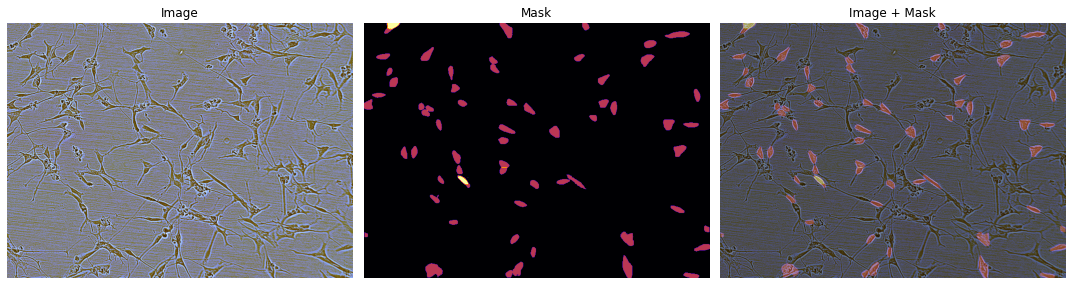

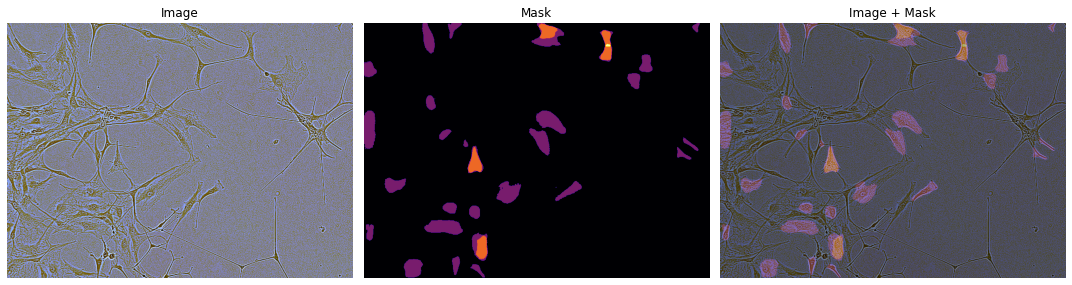

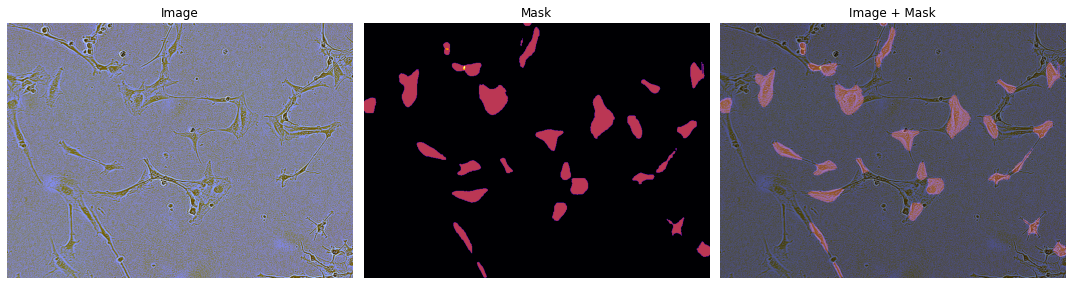

In [9]:
for ii in range(3):
    image_id = annos[ii]['filename'].replace('.jpg','').replace('.png','')
    for class_id in range(1):
        #print(ii,class_id,len(result[ii][0][class_id]), len(result[ii][1][class_id]))
        bbs = result[ii][0][class_id]
        sgs = result[ii][1][class_id]
        for idx, (bb, sg) in enumerate(zip(bbs,sgs)):
            box = bb[:4]
            cnf = bb[4]
            h = sg['size'][0]
            w = sg['size'][0]
            if cnf > 0.1:
#                 print(f'class_id:{class_id}, image_id:{image_id}, confidence:{cnf}')
                if idx==0:
                    mask = mutils.decode(sg)
                else:
                    mask+=mutils.decode(sg)
        print_masked_img(image_id, mask)

# Fix-Overlap
<pre>
The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. It also checks that no two predicted masks for the same image are overlapping.
</pre>

In [10]:
import cupy as cp
import gc

def one_hot(y, num_classes, dtype=cp.uint8): # GPU
    y = cp.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = cp.max(y) + 1
    n = y.shape[0]
    categorical = cp.zeros((n, num_classes), dtype=dtype)
    categorical[cp.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = cp.reshape(categorical, output_shape)
    return categorical

def fix_overlap(msk): # GPU
    """
    Args:
        mask: multi-channel mask, each channel is an instance of cell, shape:(520,704,None)
    Returns:
        multi-channel mask with non-overlapping values, shape:(520,704,None)
    """
    msk = cp.array(msk)
    msk = cp.pad(msk, [[0,0],[0,0],[1,0]]) # add dummy mask for background
    ins_len = msk.shape[-1]
    msk = cp.argmax(msk,axis=-1)# convert multi channel mask to single channel mask, argmax will remove overlap
    msk = one_hot(msk, num_classes=ins_len) # back to multi-channel mask, some instance might get removed
    msk = msk[...,1:] # remove background mask
    msk = msk[...,cp.any(msk, axis=(0,1))] # remove all-zero masks
    #assert np.prod(msk, axis=-1).sum()==0 # overlap check, will raise error if there is overlap
    return msk

def check_overlap(msk):
    msk = msk.astype(cp.bool).astype(cp.uint8) # binary mask
    return cp.any(cp.sum(msk, axis=-1)>1) # only one channgel will contain value

# Submission

In [11]:
data = []
for ii in tqdm(range(len(annos))):
    image_id = annos[ii]['filename'].replace('.jpg','').replace('.png','')
    mask = []
    for class_id in range(1):
        bbs = result[ii][0][class_id]
        sgs = result[ii][1][class_id]
        for bb, sg in zip(bbs,sgs):
            box = bb[:4]
            cnf = bb[4]
            h = sg['size'][0]
            w = sg['size'][1]
            #convert coco format to kaggle format
            mask.append(cp.array(mutils.decode(sg)))
        mask = cp.stack(mask, axis=-1)
        if check_overlap(mask): # if mask instances have overlap then fix it
            mask = fix_overlap(mask)
        for idx in range(mask.shape[-1]):
            mask_ins = mask[...,idx]
            rle  = mask2rle(mask_ins)
            data.append([image_id, rle])
#             del mask_ins
#             gc.collect()
        del mask, rle, sgs, bbs
        gc.collect()
pred_df = pd.DataFrame(data, columns=['id','predicted'])

  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
sub_df  = pd.read_csv('../input/sartorius-cell-instance-segmentation/sample_submission.csv')
del sub_df['predicted']
sub_df = sub_df.merge(pred_df, on='id', how='left')
sub_df.to_csv('submission.csv',index=False)
sub_df.head()

,id,predicted
0,7ae19de7bc2a,140004 18 140707 21 141410 23 142114 23 142818...
1,7ae19de7bc2a,96418 5 97121 6 97825 7 98528 9 99232 9 99936 ...
2,7ae19de7bc2a,178194 3 178897 4 179600 6 180304 6 181007 7 1...
3,7ae19de7bc2a,139541 5 140245 7 140948 8 141652 9 142356 9 1...
4,7ae19de7bc2a,183926 4 184629 7 185333 7 186037 8 186740 10 ...


In [13]:
!ls -l 

total 1664
---------- 1 root root 1663753 Oct 21 08:23 __notebook__.ipynb
-rw-r--r-- 1 root root   36411 Oct 21 08:23 submission.csv


# Reference
* [mmdetection for segmentation [inference]](https://www.kaggle.com/its7171/mmdetection-for-segmentation-inference) by @its7171

# Please Upvote If you find this notebook Useful :)